In [65]:
#@title Packages
import functools

import jax
import jax.numpy as jnp
import numpy as onp
from sklearn.metrics.pairwise import rbf_kernel as rbf_sklearn
# Plotting libraries
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper'])

In [66]:
#@title Plot Functions

def plot_kernel_mat(K):
    # plot
    plt.figure()
    plt.imshow(K, cmap='Reds')
    plt.title(r'$K_{ff}$, (rbf)', fontsize=20, weight='bold')
    plt.tight_layout()
    plt.show()

In [67]:
#@title Data

def get_1d_data(N=30, sigma_inputs=0.15, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X = jnp.linspace(-10, 10, N)
    # Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y = jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * X))
    Y += sigma_obs * onp.random.randn(N)
    X += sigma_inputs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)



    X_test = jnp.linspace(-11, 11, N_test) 
    X_test += sigma_inputs * onp.random.randn(N_test)

    X = X[:, None]
    X_test = X[:, None]

    assert X.shape == (N,1)
    assert Y.shape == (N,)

    return X, Y, X_test

def get_2d_data(N=30, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X1 = jnp.linspace(-10, 10, N)
    X2 = jnp.linspace(-5, 2, N)
    # Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y = jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * X1)) + jnp.exp(X2)
    Y += sigma_obs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)



    X1_test = jnp.linspace(-11, 11, N_test)
    X2_test = jnp.linspace(-6, 4, N_test) 

    X = jnp.vstack((X1,X2)).T
    X_test = jnp.vstack((X1_test,X2_test)).T

    assert X.shape == (N,2)
    assert Y.shape == (N,)

    return X, Y, X_test

# Get Data
X, Y, X_test = get_1d_data(100, sigma_inputs=0.0, sigma_obs=0.1, N_test=100)

In [68]:
#@title Kernel Functions

# Squared Euclidean Distance Formula
@jax.jit
def sqeuclidean_distance(x, y):
    return jnp.sum((x-y)**2)

# RBF Kernel
@jax.jit
def rbf_kernel(params, x, y):
    return jnp.exp( - params['gamma'] * sqeuclidean_distance(x, y))
    
# Covariance Matrix
def covariance_matrix(kernel_func, x, y):
    mapx1 = jax.vmap(lambda x, y: kernel_func(x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)

In [69]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X[:1, :]
test_Y = X[:1, :]

rbf_x_sk = rbf_sklearn(
    onp.array(test_X.reshape(1, -1)), 
    onp.array(test_Y.reshape(1, -1)), 
    gamma=1.0
)
print(rbf_x_sk.shape, test_X.shape)

params = {'gamma': 1.0, 'var_f': 1.0}
gamma = 1.0
rbf_k_ = functools.partial(rbf_kernel, params)
rbf_x = rbf_k_(
    test_X.squeeze(), 
    test_Y.squeeze()
)

onp.testing.assert_array_almost_equal(onp.array(rbf_x), rbf_x_sk)

(1, 1) (1, 2)


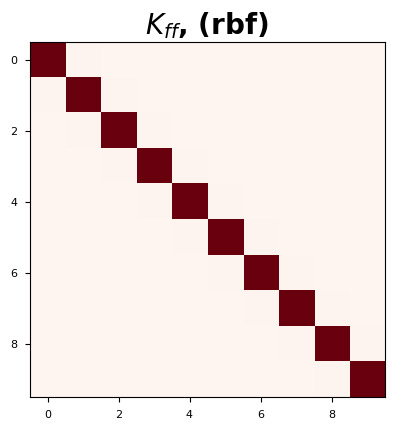

In [70]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X.copy()#[:2, :]
test_Y = X.copy() #[:2, :]

rbf_x_sk = rbf_sklearn(
    onp.array(test_X), 
    onp.array(test_Y), 
    gamma=1.0
)

params = {'gamma': 1.0, 'var_f': 1.0}
rbf_k_ = functools.partial(rbf_kernel, params)
rbf_x = covariance_matrix(
    rbf_k_,
    test_X, 
    test_Y
)

onp.testing.assert_array_almost_equal(onp.array(rbf_x), rbf_x_sk)

plot_kernel_mat(rbf_x)

In [71]:
X, Y, X_test = get_1d_data(10, sigma_obs=0.1)

test_X = X[0:1, :]
test_Y = X[1:2, :]
print(test_X.shape, test_Y.shape)

(1, 1) (1, 1)


In [72]:
def drbf_kernel_scratch(gamma, X, Y):
    # initialize matrix
    dK_fg_ = onp.empty(X.shape[-1])
    
    constant = - 2 * gamma
    
    # calculate kernel matrix w. sklearn kernel
    k_val = rbf_sklearn(onp.array(X), onp.array(Y), gamma=gamma)
    
    # loop through features/dimensions
    for idim in range(X.shape[1]):
        
        x_val = X[:, idim] - Y[:, idim]

        dK_fg_[idim] = constant * k_val *  x_val 
    return dK_fg_

drbf_kernel_scratch(1.0, test_X, test_Y)


array([0.01392619])

In [73]:
X, Y, X_test = get_1d_data(10, sigma_obs=0.1)

test_X = X
test_Y = X

In [74]:
dK_fg_ = onp.empty((test_X.shape[0], test_X.shape[0]))

for i in range(test_X.shape[0]):
    for j in range(test_Y.shape[0]):
        
        dK_fg_[i, j] = drbf_kernel_scratch(gamma, onp.array(test_X[i, :]).reshape(1,-1), onp.array(test_Y[j, :]).reshape(1, -1))
dK_fg_.shape

(10, 10)

In [63]:
def d2rbf_kernel_scratch_jac(gamma, X, Y):
    d2K_fg2_ = onp.empty(X.shape[-1])
    
    constant = 2 * gamma
    
    k_val = rbf_sklearn(onp.array(X), onp.array(Y), gamma=gamma)
    
    for idim in range(X.shape[1]):
        
        # compute the xterm: 2 gamma (xj - yj)^2
        x_val = constant * (X[:, idim] - Y[:, idim]) ** 2 - 1

        # compute the derivative term
        d2K_fg2_[idim] = constant * x_val * k_val 
    return d2K_fg2_
d2rbf_kernel_scratch_jac(1.0, test_X, test_Y)

ValueError: setting an array element with a sequence.

In [49]:
# initialize matrix
d2K_fg2_ = onp.empty((test_X.shape[0], test_X.shape[0], test_X.shape[1]))

for i in range(test_X.shape[0]):
    for j in range(test_Y.shape[0]):
        
        d2K_fg2_[i, j, :] = d2rbf_kernel_scratch_jac(gamma, onp.array(test_X[i, :]).reshape(1,-1), onp.array(test_Y[j, :]).reshape(1, -1))
d2K_fg2_.shape

(10, 10, 1)

In [50]:
# define the cross operator K_fg(x, y), dK wrt x
dK_fg_func = jax.hessian(rbf_kernel, argnums=(1))

K_func = functools.partial(dK_fg_func, params)
d2K_fg2 = covariance_matrix(K_func, test_X, test_Y)

d2K_fg2.shape

(10, 10, 1, 1)

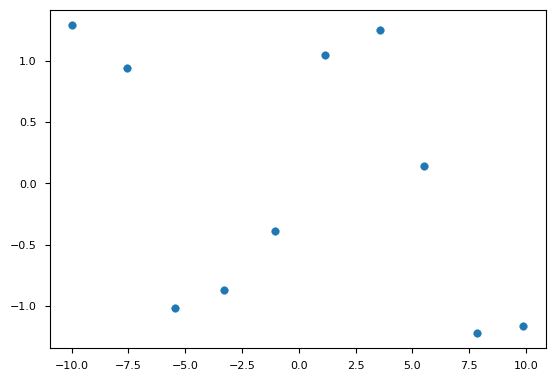

In [51]:
plt.scatter(test_X,Y)

In [52]:
K_gf = covariance_matrix(rbf_k_, test_X, test_Y).dot(d2K_fg2.T)
K_gf.shape

(10, 1, 1, 10)

In [53]:
def posterior_distribution(X, targets,x_test, k,l = 1,sigma_f=1, sigma_n = 1, ):
    K = k(X, X, l=l, sigma_f_sq = sigma_f) + sigma_n * np.eye(len(X))
    K_s = k(X, x_test,l=l, sigma_f_sq = sigma_f)
    K_ss = k(x_test, x_test,l=l, sigma_f_sq = sigma_f)

    L = onp.linalg.cholesky(K)
    alpha = onp.linalg.solve(L.T, jnp.linalg.solve(L, targets))

    f_star = onp.dot(K_s.T, alpha)
    v = onp.linalg.solve(L, K_s)
    var_f_star = K_ss - onp.dot(v.T, v)
    
    return f_star, var_f_star